In [1]:
!pip install utils

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings; warnings.filterwarnings("ignore")
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import statannot
import warnings
import dabest
import utils
#plt.style.use('fivethirtyeight')

In [4]:
GeneOfInterest = "LAG3"

In [5]:
RNAseq_url = "https://github.com/riazn/bms038_analysis/blob/master/data/CountData.BMS038.txt"
clinical_url = "https://github.com/riazn/bms038_analysis/blob/master/data/bms038_clinical_data.csv"

In [6]:
df_exp = pd.read_csv(RNAseq_url+"?raw=true", header=0, sep="\t", error_bad_lines=False)
df_exp = df_exp.loc[df_exp["HUGO"] == GeneOfInterest]
df_exp = pd.melt(df_exp, id_vars=["HUGO"], var_name="Sample", value_name="Count")
df_exp.rename(columns = {"HUGO": "GeneID"}, inplace=True)
df_exp[["PatientID","Treatment"]] = df_exp["Sample"].str.split("_", expand=True)	
first_column = df_exp.pop("PatientID"); df_exp.insert(0, 'PatientID', first_column)
df_exp.drop(["Sample"], axis=1, inplace=True)
df_exp["Treatment"] = df_exp["Treatment"].str.replace(r".2","")

In [7]:
df_clin = pd.read_csv(clinical_url+"?raw=true", header=0, sep=",", error_bad_lines=False)
df_clin = df_clin[["PatientID","myBOR"]]
print(df_clin.shape)

(73, 2)


In [8]:
df =pd.merge(df_exp, df_clin, how="inner", on="PatientID")
df = df.sort_values(by="Treatment", ascending=False)
df.head(2)

,PatientID,GeneID,Count,Treatment,myBOR
55,Pt47,LAG3,54,Pre,PD
57,Pt48,LAG3,167,Pre,PRCR


In [9]:
TreatmentTypes = df.Treatment.unique().tolist(); print(TreatmentTypes)
ResponseTypes  = df.myBOR.unique().tolist(); print(ResponseTypes)

['Pre', 'On']
['PD', 'PRCR', 'SD']


In [10]:
resp_palette = sns.dark_palette("#8BF", reverse=False, n_colors=2)
treat_palette = sns.color_palette("YlGn", n_colors=2)
resp_palette
treat_palette

[(0.7359477124183007, 0.8915032679738563, 0.5843137254901961),
 (0.21568627450980393, 0.6196078431372549, 0.330718954248366)]

In [11]:
resp_order  = ["PRCR", "SD", "PD"] # PD = Progressive Disease; SD = StabLe Disease; PR/CR = Partial / CompLete Response
treat_order = ["pre","on"]
              
pairs = [(("PRCR","On"),("PRCR","Pre")),(("SD","On"),("SD","Pre")),(("PD","On"),("PD","Pre")),
         (("PRCR","Pre"),("SD","Pre")),(("PRCR","Pre"),("PD","Pre"))]
hue_plot_params = {'data': df, 'x':"myBOR", 'y': 'Count', "hue": "Treatment", "palette": resp_palette}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SD_Pre vs. SD_On: Mann-Whitney-Wilcoxon test two-sided, P_val:7.691e-02 U_stat=1.190e+02
PRCR_Pre vs. PRCR_On: Mann-Whitney-Wilcoxon test two-sided, P_val:2.122e-01 U_stat=4.100e+01
PD_Pre vs. PD_On: Mann-Whitney-Wilcoxon test two-sided, P_val:2.128e-01 U_stat=2.460e+02
PRCR_Pre vs. SD_Pre: Mann-Whitney-Wilcoxon test two-sided, P_val:9.641e-01 U_stat=1.005e+02
PRCR_Pre vs. PD_Pre: Mann-Whitney-Wilcoxon test two-sided, P_val:2.465e-01 U_stat=1.850e+02


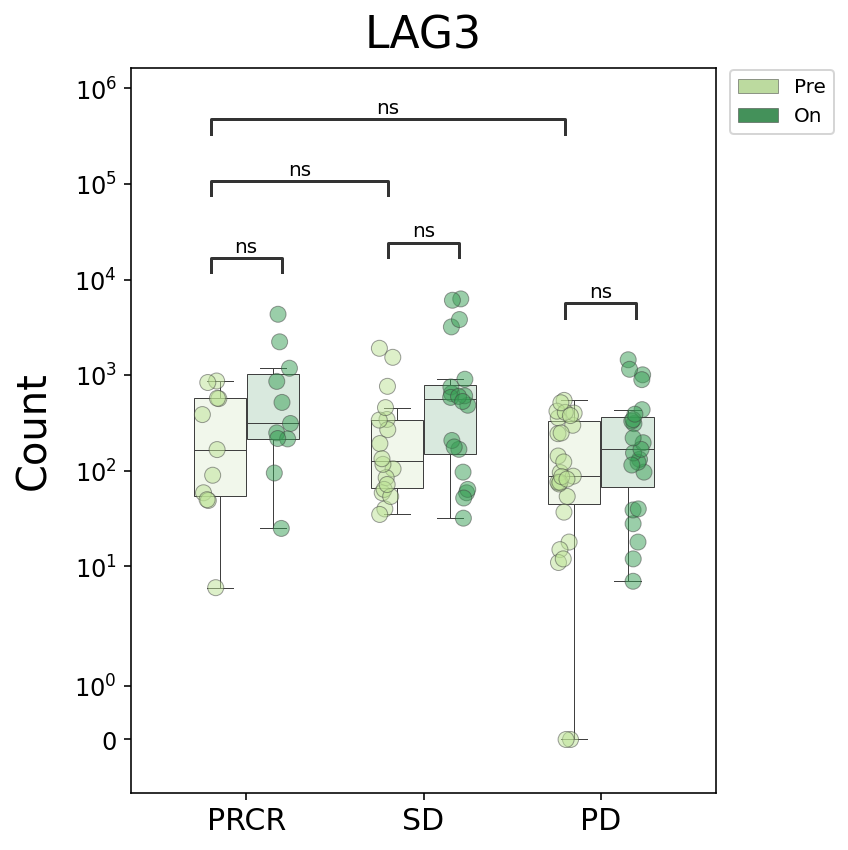

Wall time: 1.04 s


In [15]:
%%time
fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(wspace=0.02, hspace=0.01)
sns.plotting_context("notebook", font_scale = 1.4)
ax = sns.stripplot(data=df, x="myBOR", y="Count", order = resp_order, hue="Treatment", jitter=True, dodge=True,
                   palette = treat_palette, linewidth=0.5, size=8, split=True, edgecolor='gray', alpha=.5)
ax = sns.boxplot(ax=ax, data=df, x='myBOR', y='Count', order = resp_order, hue="Treatment",
                 palette = treat_palette, width=0.6, fliersize=0, linewidth=0.5)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.1)
plt.gca().set_yscale('symlog'); plt.ylim(-1, 1e6) 
ax.set_title(GeneOfInterest, fontsize=22, pad=10)
plt.xlabel("", labelpad=10); plt.ylabel("Count", fontsize=20, labelpad=10) 
plt.xticks(fontsize=15, rotation=0); plt.yticks(fontsize=12, rotation=0)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor() 
    patch.set_facecolor((r, g, b,.2))
    
annotator = Annotator(ax, pairs, order=resp_order, **hue_plot_params)
annotator.configure(test='Mann-Whitney', text_format='star').apply_and_annotate()

plt.tight_layout()
plt.show()

In [13]:
df_pivot = df.pivot(index='PatientID', columns= 'myBOR', values='Count')
df_pivot.head()

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
analysis_of_long_df = dabest.load(df, idx=("PRCR","SD","PD"), x="myBOR", y="Count", resamples=5000)
analysis_of_long_df

In [ ]:
# analysis_of_long_df.mean_diff.plot(swarm_label="This is my\nrawdata", contrast_label="The bootstrap\ndistribtions!")

In [ ]:
multi_groups = dabest.load(df, idx=("myBOR","Treatment"))

multi_2group_paired = dabest.load(df, idx=(("Control 1", "Test 1"), ("Control 2", "Test 2")), paired=True, id_col="ID")



multi_2group_paired.mean_diff.plot

In [ ]:
f, axx = plt.subplots(nrows=2, ncols=2,
                        figsize=(15, 15),
                        gridspec_kw={'wspace': 0.25} # ensure proper width-wise spacing.
                       )

two_groups_unpaired.mean_diff.plot(ax=axx.flat[0]);
two_groups_paired.mean_diff.plot(ax=axx.flat[1]);
multi_2group.mean_diff.plot(ax=axx.flat[2]);
multi_2group_paired.mean_diff.plot(ax=axx.flat[3]);